<a href="https://colab.research.google.com/github/sarcasticvibes/CRNN-for-Hindi-Text-Recognition/blob/master/CRNN_for_Hindi_Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
! pip install albumentations --upgrade

     |████████████████████████████████| 122kB 2.6MB/s 
     |████████████████████████████████| 634kB 4.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=753c659d833757a453fea3aa2931cbebc0dfab60725373f626d0060536aa4834
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=6d01fcbbe0e10a47bc3454df71663deffd8682556afa8f46427501e535cc04d5
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [191]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch

import cv2
from google.colab.patches import cv2_imshow
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np

device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
! unzip captcha_dataset.zip

In [47]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))
        self.dropout  = nn.Dropout(p=.3)


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        conv = self.dropout(conv)

        # rnn features
        output = self.rnn(conv)
        output = self.dropout(output)
        # add log_softmax to converge output
        output = F.log_softmax(output, dim=2)

        return output


    def backward_hook(self, module, grad_input, grad_output):
        for g in grad_input:
            g[g != g] = 0   # replace all nan/inf in gradients to zero

In [48]:
model = CRNN(256, 3, 24, 256)

In [49]:
model

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [59]:
import os
a = os.listdir('/content/cropped_data/cropped_dir')[0]
img = cv2.imread(f'/content/cropped_data/cropped_dir/{a}')

In [56]:
a

'1010.jpg'

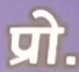

In [60]:
cv2_imshow(img)

In [ ]:
! tar -xvf cropped_data.tar

In [36]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)
pad_char = '-PAD-'
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [37]:
def gt_rep(word, letter2index, device = device_gpu):
    gt_rep = torch.zeros([len(word), 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    #gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [41]:
#Function to convert a batch of labels to coresponding represtentation that can be passed to the CRNN model
def label_rep(labels, device = device_gpu, letter2index = hindi_alpha2index):
  gt = []
  len_ = torch.zeros(len(labels), dtype=torch.long).to(device)
  for label in labels:
    gt.append(gt_rep(ground_truth[label], letter2index, device))
  rep = torch.zeros([len(labels),max(len(x) for x in gt) ], dtype=torch.long).to(device)
  for index, label in enumerate(gt):
    for i, char in enumerate(label):
      rep[index][i] = char
    len_[index] = len(label)
  return len_, rep

In [46]:
#Function to perform one training step given a batch of input images and their ground truths
#We are using CTC loss function as our loss function
def train_batch(net, opt, criterion, images, labels, device = device_gpu, batch_size = 10):
    
    net.train().to(device)
    opt.zero_grad()

    input = images
    outputs = net(input)
    input_lengths = torch.full(size=(batch_size,), fill_value = 31, dtype=torch.long)
    target_lengths, target = label_rep(labels, device = device, letter2index = hindi_alpha2index)
    loss = criterion(outputs, target, input_lengths, target_lengths)
    opt.step()
    return loss

In [42]:
#Training driver function which takes the hyper parameters and works accordingly
def train_setup(net, lr = 0.01, n_epochs = 10, batch_size = 10, momentum = 0.9, display_freq=5, device = device_gpu):
    
    net = net.to(device)
    criterion = nn.CTCLoss()
    opt = optim.AdamW(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim, mode='min', patience=5, factor=.3)
    for e in range(n_epochs):
      
      trainloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
      n_batches = len(trainloader)-1
      dataiter = iter(trainloader)
      loss_arr = np.zeros(n_batches)


      for i, data in tqdm_notebook(enumerate(trainloader), total = n_batches, unit = "epoch"):
          images, labels = data['image'], data['label']
          images = images.to(device)
          labels = labels.to(device)
          loss_arr[i] = train_batch(net, opt, criterion, images, labels, device = device, batch_size = batch_size)
          
          if e%display_freq == display_freq-1:
              clear_output(wait=True)
              
              print('Epoch',e,'Iteration', i, 'Loss', loss_arr[:i+1].mean())
              print('\n\n')
      scheduler.step()  
    torch.save(net.state_dict(), 'model.pt')
    return loss_arr

In [61]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=32, width=64, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=32, width=64, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0
    )

In [200]:
class DataLoader:
  def __init__(self, test=False):
    if test:
      self.aug = get_valid_transforms()
    else:
      self.aug = get_train_transforms()
    
    self.image_ids = enumerate(os.listdir('/content/cropped_data/cropped_dir'))
    with open('/content/cropped_data/annotations.txt') as f:
      gt = f.read()
      gt = list(gt.split('\n'))
      gt = list(map(str.split, gt))
      label = []
      for i, anno in enumerate(gt):
        gts = [a for a in anno]
        if(len(gts)<2):
          continue
        label.append(gts[1])
    self.labels = label
  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, item):
    image = cv2.imread(f'/content/cropped_data/cropped_dir/{item}.jpg')
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = self.aug(image = np.array(image))['image']
    #image = np.transpose(image, (2, 0, 1))
    return {
        'image':image,
        'label':self.labels[item]
    }

In [201]:
dataset = DataLoader()

In [202]:
dataset[5]['image'].shape

torch.Size([3, 32, 64])